In [1]:
import decode_eeg
import numpy as np
import matplotlib.pyplot as plt
import mne
np.random.seed(42)
%load_ext autoreload
%autoreload 2

In [2]:
experiment_name = '1801'
data_dir = f'./data/{experiment_name}'
exp = decode_eeg.Experiment(experiment_name,data_dir,test=False)

In [3]:
time_window = 25
time_step = 25
trial_average = 20
n_splits = 15
group_dict = {0:[1],1:[2],2:[3],3:[4]}
wrangl = decode_eeg.Wrangler(exp.info['times'],time_window,time_step,trial_average,n_splits,group_dict)

clfr = decode_eeg.Classification(wrangl,exp.nsub)

In [94]:
bands = [[0,0],[1,3],[3,8],[8,13],[13,30]]
clfr.acc = np.zeros((clfr.nsub,len(bands),np.size(clfr.t),clfr.n_splits))*np.nan
clfr.acc_shuff = np.zeros((clfr.nsub,len(bands),np.size(clfr.t),clfr.n_splits))*np.nan
clfr.conf_mat = np.zeros((clfr.nsub,len(bands),np.size(clfr.t),clfr.n_splits,clfr.num_labels,clfr.num_labels))*np.nan

for wrangl.ielec,band in enumerate(bands):
        
    for isub in range(exp.nsub):
        print(isub)
        xdata,ydata = exp.load_eeg(isub)
        if wrangl.ielec > 0:
            xdata = add_power(xdata,exp,lower=band[0],upper=band[1])
        xdata,ydata = wrangl.setup_data(xdata,ydata)

        for X_train_all, X_test_all, y_train, y_test in wrangl.train_test_split(xdata,ydata):
            for X_train, X_test in wrangl.roll_over_time(X_train_all, X_test_all):
                clfr.decode_electrode_subset(X_train,X_test,y_train,y_test,isub)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


In [95]:
interp = decode_eeg.Interpreter(clfr, subtitle = f'{experiment_name}_trialbin{str(trial_average)}_power_')
interp.save_results()
# interp.load_results('1901_trialbin20_bin20_20200907_1600.pickle')

Saving output\figures\1901_trialbin20_power_acc20200907_1814.pdf
Saving output\figures\1901_trialbin20_power_acc20200907_1814.png


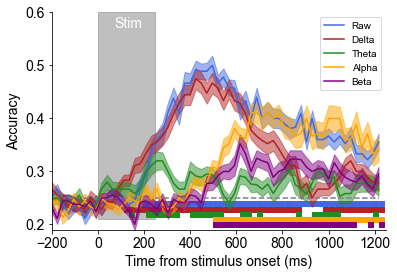

In [97]:
interp.plot_acc_subset( ['Raw','Delta','Theta','Alpha','Beta'],significance_testing=True,ylim=[.19,.6],chance=.25,sig_ys = [.24,.23,.22,.21,.2],savefig=1)

In [19]:
erp = decode_eeg.ERP(exp,subtitle='1801')
xdata,ydata = exp.load_eeg(0)

In [128]:
xdata_filt, xdata_power = add_power(xdata,exp,lower=8,upper=13)

Applying baseline correction (mode: mean)


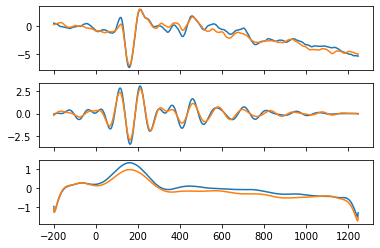

In [131]:

trial = ydata==1
xdata_po,xdata_filt_po,xdata_power_po = np.mean(xdata[trial],0),np.mean(xdata_filt[trial],0),np.mean(xdata_power[trial],0)

xdata_po = erp._select_electrodes(xdata_po,('P','O'))
xdata_filt_po = erp._select_electrodes(xdata_filt_po,('P','O'))
xdata_power_po = erp._select_electrodes(xdata_power_po,('P','O'))

fig, axs = plt.subplots(3, 1, sharex=True, sharey=False)
axs[0].plot(erp.info['times'],np.mean(xdata_po,0),);
axs[1].plot(erp.info['times'],np.mean(xdata_filt_po,0));
axs[2].plot(erp.info['times'],np.mean(xdata_power_po,0));

trial = ydata==2
xdata_po,xdata_filt_po,xdata_power_po = np.mean(xdata[trial],0),np.mean(xdata_filt[trial],0),np.mean(xdata_power[trial],0)

xdata_po = erp._select_electrodes(xdata_po,('P','O'))
xdata_filt_po = erp._select_electrodes(xdata_filt_po,('P','O'))
xdata_power_po = erp._select_electrodes(xdata_power_po,('P','O'))

axs[0].plot(erp.info['times'],np.mean(xdata_po,0),);
axs[1].plot(erp.info['times'],np.mean(xdata_filt_po,0));
axs[2].plot(erp.info['times'],np.mean(xdata_power_po,0));

In [99]:
def add_power(xdata,exp,lower=None,upper=None,lower_upper_list=None):
    
    # convert to MNE epochs array
    info = mne.create_info(list(exp.info['chan_labels']),500,'eeg')
    eeg = mne.EpochsArray(xdata,info=info,tmin=-.2,baseline=(-.2,0),verbose=False)
    
    # apply filter and get filtered data
    eeg.filter(lower,upper,n_jobs=1,l_trans_bandwidth=1,h_trans_bandwidth=1,verbose=False)
    eeg_filt = eeg.copy()
    xdata_filt = eeg_filt.get_data()
    
    # apply hilbert and rebaseline power
    eeg.apply_hilbert(envelope=True,verbose=False)
    eeg.apply_baseline((-.2,0))
    xdata_power = eeg.get_data()

    return xdata_filt, xdata_power